# E-Commerce Healthcare Orders Dataset

## Context
The dataset used for this notebook contains data of an healthcare company. The healthcare company faces an issue. There are high return rates of products in India. The goal of this notebook is to find patterns of why products are returned.

## Source
The dataset is from Kaggle and can be found on https://www.kaggle.com/adishgolechha/ecommerce-healthcare-orders-dataset.

## Description		
| Variable | Description |
| :- | :- |
| Serial Number | Serial number of product |
| ID | Unique Order ID assigned as key to every order |
| Name | Customer Name |
| City | City where the order is delivered |
| State | State where the order is delivered |
| Address | Delivery Address |
| isCOD | A Boolean of if the order is cash on delivery or not |
| Date Placed | Date the order is placed |
| Status | Status of the order - being Delivered or Returned |
| IVR | A confirmation of payment status, pre-paid orders are IVR confirmed |
| Remarks | Internal field, handled by Customer Service Agents |
| Total | Order total |
| Date Delivered | Date of delivery of product |
| Date Returned | Date where product was returned (only filled if returned) |
| PID | NaN |
| Category | Product category |
| Quantity | Quantatiy of ordered product |
| Product Name | Name of ordered product |

In [1]:
import os
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import csv
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")

## Data Import

In [2]:
path = r"data\OrdersCleaned.csv"
df = pd.read_csv(path, encoding = "ISO-8859-1")
df.head()

,Unnamed: 0,ID,Name,City,State,Address,isCOD,Date Placed,Status,IVR,Remarks,Total,Date Delivered,Date Returned,PID,Category,Quantity,Product Name
0,0,30145,Man,Nayagarh,Odisha,"Jagadish Prasad, Golapokhari-Bhapur Road, Fate...",True,2021-01-31 17:45:59,Delivered,Confirmed,pickrr,999,2021-02-14 04:37:00,NaN,32,WL,2,One Week Weight-Loss (Peach)
1,1,30144,Dik,Thane,Maharashtra,"Shanti Garden Sector 4 , flat 401, building 2,...",True,2021-01-31 17:33:57,Delivered,Confirmed,NaN,599,2021-02-02 23:19:18,NaN,23,D,2,One Week Detox Trial
2,2,30143,Shi,Bangalore,Karnataka,"#280 2nd main 2nd cross, vinobha nagar kg halli",True,2021-01-31 17:33:02,Delivered,Confirmed,On call,599,2021-02-08 00:08:25,NaN,23,D,2,One Week Detox Trial
3,3,30142,Pre,Mumbai,Maharashtra,"1404/ Accord Nidhi, above Bikaji, Link Road, M...",True,2021-01-31 17:31:57,Delivered,Confirmed,Script,3596,2021-02-09 03:17:08,NaN,34,WL,2,One Month Weight-Loss (Peach)
4,4,30138,Dr.,Pauri Garhwal,Uttarakhand,"10 am to 3 pm, Please call Before Coming, Room...",True,2021-01-31 17:06:55,Delivered,Confirmed,Script,999,2021-02-04 01:59:40,NaN,31,WL,2,One Week Weight-Loss (Mint)


In [3]:
# rename "Unnamed: 0" to "Serial Number"
df = df.rename(columns={df.columns[0]: "Serial Number"})
df.head()

,Serial Number,ID,Name,City,State,Address,isCOD,Date Placed,Status,IVR,Remarks,Total,Date Delivered,Date Returned,PID,Category,Quantity,Product Name
0,0,30145,Man,Nayagarh,Odisha,"Jagadish Prasad, Golapokhari-Bhapur Road, Fate...",True,2021-01-31 17:45:59,Delivered,Confirmed,pickrr,999,2021-02-14 04:37:00,NaN,32,WL,2,One Week Weight-Loss (Peach)
1,1,30144,Dik,Thane,Maharashtra,"Shanti Garden Sector 4 , flat 401, building 2,...",True,2021-01-31 17:33:57,Delivered,Confirmed,NaN,599,2021-02-02 23:19:18,NaN,23,D,2,One Week Detox Trial
2,2,30143,Shi,Bangalore,Karnataka,"#280 2nd main 2nd cross, vinobha nagar kg halli",True,2021-01-31 17:33:02,Delivered,Confirmed,On call,599,2021-02-08 00:08:25,NaN,23,D,2,One Week Detox Trial
3,3,30142,Pre,Mumbai,Maharashtra,"1404/ Accord Nidhi, above Bikaji, Link Road, M...",True,2021-01-31 17:31:57,Delivered,Confirmed,Script,3596,2021-02-09 03:17:08,NaN,34,WL,2,One Month Weight-Loss (Peach)
4,4,30138,Dr.,Pauri Garhwal,Uttarakhand,"10 am to 3 pm, Please call Before Coming, Room...",True,2021-01-31 17:06:55,Delivered,Confirmed,Script,999,2021-02-04 01:59:40,NaN,31,WL,2,One Week Weight-Loss (Mint)


## Initial EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Serial Number   1590 non-null   int64 
 1   ID              1590 non-null   int64 
 2   Name            1590 non-null   object
 3   City            1586 non-null   object
 4   State           1586 non-null   object
 5   Address         1590 non-null   object
 6   isCOD           1590 non-null   bool  
 7   Date Placed     1590 non-null   object
 8   Status          1590 non-null   object
 9   IVR             1590 non-null   object
 10  Remarks         919 non-null    object
 11  Total           1590 non-null   int64 
 12  Date Delivered  1401 non-null   object
 13  Date Returned   187 non-null    object
 14  PID             1555 non-null   object
 15  Category        1587 non-null   object
 16  Quantity        1590 non-null   int64 
 17  Product Name    1590 non-null   object
dtypes: bool(

The column "Date Returned" contains a lot of missing values. I think that this feature has no influence on the output, because when it should be predicted whether a product is returned or not, than it does not make sense to have a return date, because the product is not returned yet. Therefore, this feature is discarded. <br> <br>
The column "Remarks" also contains a lot of missing values. Let's later dive deeper into this feature and check, if we should discard this one or replace the missing values. <br> <br>
The columns "Date Delivered" and "Category" are also containing some missing values. Let's later try to impute them.

In [57]:
# let's drop date returned column
df_changed = df.drop(columns="Date Returned")
df_changed.head()

,Serial Number,ID,Name,City,State,Address,isCOD,Date Placed,Status,IVR,Remarks,Total,Date Delivered,PID,Category,Quantity,Product Name
0,0,30145,Man,Nayagarh,Odisha,"Jagadish Prasad, Golapokhari-Bhapur Road, Fate...",True,2021-01-31 17:45:59,Delivered,Confirmed,pickrr,999,2021-02-14 04:37:00,32,WL,2,One Week Weight-Loss (Peach)
1,1,30144,Dik,Thane,Maharashtra,"Shanti Garden Sector 4 , flat 401, building 2,...",True,2021-01-31 17:33:57,Delivered,Confirmed,NaN,599,2021-02-02 23:19:18,23,D,2,One Week Detox Trial
2,2,30143,Shi,Bangalore,Karnataka,"#280 2nd main 2nd cross, vinobha nagar kg halli",True,2021-01-31 17:33:02,Delivered,Confirmed,On call,599,2021-02-08 00:08:25,23,D,2,One Week Detox Trial
3,3,30142,Pre,Mumbai,Maharashtra,"1404/ Accord Nidhi, above Bikaji, Link Road, M...",True,2021-01-31 17:31:57,Delivered,Confirmed,Script,3596,2021-02-09 03:17:08,34,WL,2,One Month Weight-Loss (Peach)
4,4,30138,Dr.,Pauri Garhwal,Uttarakhand,"10 am to 3 pm, Please call Before Coming, Room...",True,2021-01-31 17:06:55,Delivered,Confirmed,Script,999,2021-02-04 01:59:40,31,WL,2,One Week Weight-Loss (Mint)


Now, the pandas function "describe" is called. This is always nice to get the first insights into the numerical features and their value ranges and some statistics.

In [58]:
df_changed.describe()

,Serial Number,ID,Total,Quantity
count,1590.000000,1590.000000,1590.000000,1590.000000
mean,794.500000,28909.873585,1762.896855,1.788679
std,459.137779,724.640062,1227.129226,0.655612
min,0.000000,27634.000000,0.000000,1.000000
25%,397.250000,28282.250000,799.000000,1.000000
50%,794.500000,28912.500000,999.000000,2.000000
75%,1191.750000,29537.750000,2876.000000,2.000000
max,1589.000000,30145.000000,7992.000000,12.000000


Seems like Serial Number and ID columns are only containing unique values. Let's check that and drop them in case that's true, because columns with only unique values are not delivering any usefull features for machine learning.

In [59]:
for col in df.columns:
    print(f"Column {col} contains {len(df[col].unique())} unique values ({ 100 * len(df[col].unique()) / df.shape[0]}% of total data).")

Column Serial Number contains 1590 unique values (100.0% of total data).
Column ID contains 1590 unique values (100.0% of total data).
Column Name contains 532 unique values (33.459119496855344% of total data).
Column City contains 306 unique values (19.245283018867923% of total data).
Column State contains 36 unique values (2.2641509433962264% of total data).
Column Address contains 1557 unique values (97.9245283018868% of total data).
Column isCOD contains 2 unique values (0.12578616352201258% of total data).
Column Date Placed contains 1578 unique values (99.24528301886792% of total data).
Column Status contains 3 unique values (0.18867924528301888% of total data).
Column IVR contains 2 unique values (0.12578616352201258% of total data).
Column Remarks contains 63 unique values (3.9622641509433962% of total data).
Column Total contains 115 unique values (7.232704402515723% of total data).
Column Date Delivered contains 1397 unique values (87.86163522012579% of total data).
Column Da

Okay. The columns "Serial Number" and "ID" can be dropped, because they are only containing unique values. The column address is also containing a lot of unique values, but this column could be used to parse out usefull data. The date columns are important for the time series analysis! <br>
The column "Address" is also dropped, because there are too much unique values and The City should be enough geo information in my opinion.

In [60]:
df_changed = df_changed.drop(columns=["ID", "Serial Number", "Address"])
df_changed.head()

,Name,City,State,isCOD,Date Placed,Status,IVR,Remarks,Total,Date Delivered,PID,Category,Quantity,Product Name
0,Man,Nayagarh,Odisha,True,2021-01-31 17:45:59,Delivered,Confirmed,pickrr,999,2021-02-14 04:37:00,32,WL,2,One Week Weight-Loss (Peach)
1,Dik,Thane,Maharashtra,True,2021-01-31 17:33:57,Delivered,Confirmed,NaN,599,2021-02-02 23:19:18,23,D,2,One Week Detox Trial
2,Shi,Bangalore,Karnataka,True,2021-01-31 17:33:02,Delivered,Confirmed,On call,599,2021-02-08 00:08:25,23,D,2,One Week Detox Trial
3,Pre,Mumbai,Maharashtra,True,2021-01-31 17:31:57,Delivered,Confirmed,Script,3596,2021-02-09 03:17:08,34,WL,2,One Month Weight-Loss (Peach)
4,Dr.,Pauri Garhwal,Uttarakhand,True,2021-01-31 17:06:55,Delivered,Confirmed,Script,999,2021-02-04 01:59:40,31,WL,2,One Week Weight-Loss (Mint)


In [61]:
df_changed['Date Placed'] =  pd.to_datetime(df_changed['Date Placed'], infer_datetime_format=True)
df_changed['Date Delivered'] =  pd.to_datetime(df_changed['Date Delivered'], infer_datetime_format=True)

In [62]:
df_changed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Name            1590 non-null   object        
 1   City            1586 non-null   object        
 2   State           1586 non-null   object        
 3   isCOD           1590 non-null   bool          
 4   Date Placed     1590 non-null   datetime64[ns]
 5   Status          1590 non-null   object        
 6   IVR             1590 non-null   object        
 7   Remarks         919 non-null    object        
 8   Total           1590 non-null   int64         
 9   Date Delivered  1401 non-null   datetime64[ns]
 10  PID             1555 non-null   object        
 11  Category        1587 non-null   object        
 12  Quantity        1590 non-null   int64         
 13  Product Name    1590 non-null   object        
dtypes: bool(1), datetime64[ns](2), int64(2), object(9)
memor

In [63]:
# set index to date placed
df_datetime = df_changed.set_index("Date Placed")
df_datetime.head()

,Name,City,State,isCOD,Status,IVR,Remarks,Total,Date Delivered,PID,Category,Quantity,Product Name
Date Placed,,,,,,,,,,,,,
2021-01-31 17:45:59,Man,Nayagarh,Odisha,True,Delivered,Confirmed,pickrr,999,2021-02-14 04:37:00,32,WL,2,One Week Weight-Loss (Peach)
2021-01-31 17:33:57,Dik,Thane,Maharashtra,True,Delivered,Confirmed,NaN,599,2021-02-02 23:19:18,23,D,2,One Week Detox Trial
2021-01-31 17:33:02,Shi,Bangalore,Karnataka,True,Delivered,Confirmed,On call,599,2021-02-08 00:08:25,23,D,2,One Week Detox Trial
2021-01-31 17:31:57,Pre,Mumbai,Maharashtra,True,Delivered,Confirmed,Script,3596,2021-02-09 03:17:08,34,WL,2,One Month Weight-Loss (Peach)
2021-01-31 17:06:55,Dr.,Pauri Garhwal,Uttarakhand,True,Delivered,Confirmed,Script,999,2021-02-04 01:59:40,31,WL,2,One Week Weight-Loss (Mint)


Start with more detailed EDA.

In [64]:
num_features = df_datetime.columns[(df_datetime.dtypes == np.int64).values].to_list()
num_features

['Total', 'Quantity']

In [65]:
cat_features = df_datetime.columns[(df_datetime.dtypes == np.object).values].to_list()
cat_features

['Name',
 'City',
 'State',
 'Status',
 'IVR',
 'Remarks',
 'PID',
 'Category',
 'Product Name']

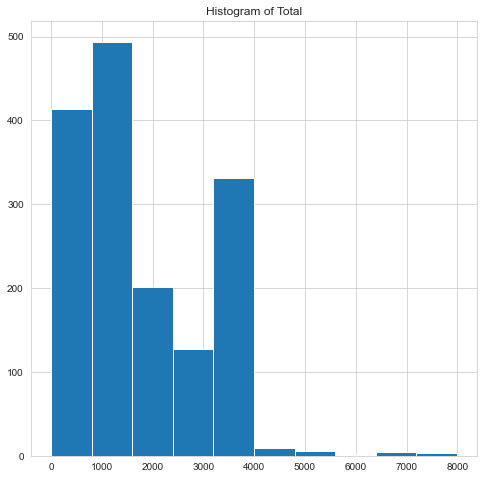

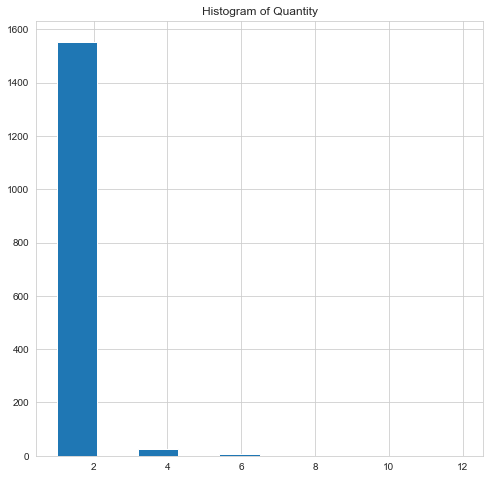

In [73]:
for numerical_feature in num_features:
    plt.title(f"Histogram of {numerical_feature}")
    plt.hist(df_datetime[numerical_feature])
    plt.show()

Numerical feautre "total" is left skewed. Let's later apply a log transformation to reduce this skewness!

In [67]:
for cat_feature in cat_features:
    print(df_datetime[cat_feature].value_counts())

Man    35
San    34
Sha    32
Pra    31
Poo    24
       ..
Zaf     1
Vpr     1
Bra     1
Piu     1
Kor     1
Name: Name, Length: 532, dtype: int64
Mumbai        130
Bangalore     128
Thane          57
Hyderabad      52
Pune           41
             ... 
Varanasi        1
Kendrapara      1
Gonda           1
Jharsuguda      1
Ramanagar       1
Name: City, Length: 305, dtype: int64
Maharashtra          284
Karnataka            186
Delhi                134
Tamil Nadu           116
Uttar Pradesh        106
Telangana             95
West Bengal           84
Gujarat               74
Andhra Pradesh        66
Haryana               64
Punjab                39
Kerala                38
Madhya Pradesh        38
Rajasthan             35
Assam                 29
Odisha                26
Jammu & Kashmir       24
Bihar                 21
Nagaland              19
Uttarakhand           15
Goa                   13
Arunachal Pradesh     11
Himachal Pradesh      10
Manipur               10
Chattisgarh     

In [68]:
cat_features

['Name',
 'City',
 'State',
 'Status',
 'IVR',
 'Remarks',
 'PID',
 'Category',
 'Product Name']

### City 
Let's investigate the categorical feature "City".

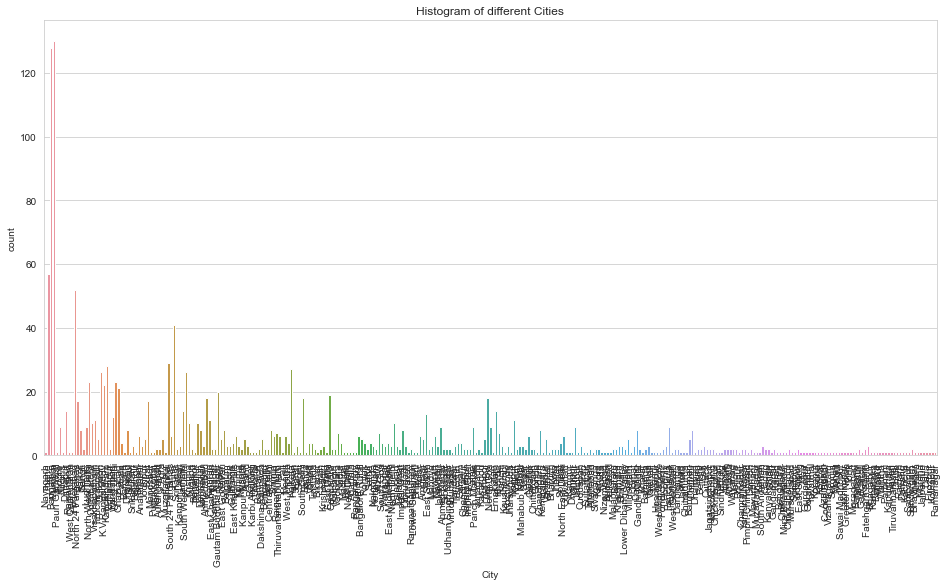

In [31]:
plt.figure(figsize=(16.0, 8.0))
sns.countplot(data=df_datetime, x="City")
plt.title("Histogram of different Cities")
plt.xticks(rotation=90)
plt.show()

In [53]:
#import geopandas as gpd

from urllib import request
#from geotext import GeoText

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

#from shapely.geometry import Point, Polygon
import descartes

# use geopy to get the coordinates of the cities
geolocator = Nominatim(user_agent="india_explorer")

lat_lon = []
for city in df_datetime["City"].to_list(): 
    try:
        location = geolocator.geocode(city)
        if location:
            lat_lon.append(location)
    except GeocoderTimedOut as e:
        print(f"Error: geocode failed on input {city} with message {e}")
lat_lon

[Location(Nayagarh, Odisha, India, (20.1160666, 85.11195643843573, 0.0)),
 Location(Thane, Maharashtra, 400602, India, (19.1943294, 72.9701779, 0.0)),
 Location(Bengaluru, Bangalore North, Bangalore Urban, Karnataka, India, (12.9791198, 77.5912997, 0.0)),
 Location(Mumbai, Mumbai Suburban, Maharashtra, India, (19.0759899, 72.8773928, 0.0)),
 Location(Pauri Garhwal, Uttarakhand, India, (29.84591115, 78.70766746320547, 0.0)),
 Location(Indore, Madhya Pradesh, 452001, India, (22.7203616, 75.8681996, 0.0)),
 Location(The Nilgiris, The Nilgiris District, Tamil Nadu, 643001, India, (11.4, 76.7, 0.0)),
 Location(Mumbai, Mumbai Suburban, Maharashtra, India, (19.0759899, 72.8773928, 0.0)),
 Location(Dimapur, Dimapur Sadar, Dimapur, Nagaland, 797112, India, (25.9136459, 93.7283456, 0.0)),
 Location(Thane, Maharashtra, 400602, India, (19.1943294, 72.9701779, 0.0)),
 Location(Rajsamand, Rajasthan, India, (25.29131615, 73.8244924740361, 0.0)),
 Location(Pashchim Champāran, Pashchim Champaran, Bihar

In [54]:
df_city_lat_lon = pd.DataFrame(lat_lon, columns=["City", "Coordinates"])
df_city_lat_lon.head()

,City,Coordinates
0,"Nayagarh, Odisha, India","(20.1160666, 85.11195643843573)"
1,"Thane, Maharashtra, 400602, India","(19.1943294, 72.9701779)"
2,"Bengaluru, Bangalore North, Bangalore Urban, K...","(12.9791198, 77.5912997)"
3,"Mumbai, Mumbai Suburban, Maharashtra, India","(19.0759899, 72.8773928)"
4,"Pauri Garhwal, Uttarakhand, India","(29.84591115, 78.70766746320547)"


In [55]:
import folium

# create map of munich using latitude and longitude values
map_cities = folium.Map(location=[df_city_lat_lon["Coordinates"][0][0], df_city_lat_lon["Coordinates"][0][1]], zoom_start=11)

# add markers to map
for coordinates, district in zip(df_city_lat_lon['Coordinates'], df_city_lat_lon['City']):
    lat, lng = coordinates
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cities)  
    
map_cities

The most returned products are from Indian customers, as one can see in the folium map. There are also some small amounts returned from Europe, from north america and from south america.

### State
Let's investigate the categorical feature "State".

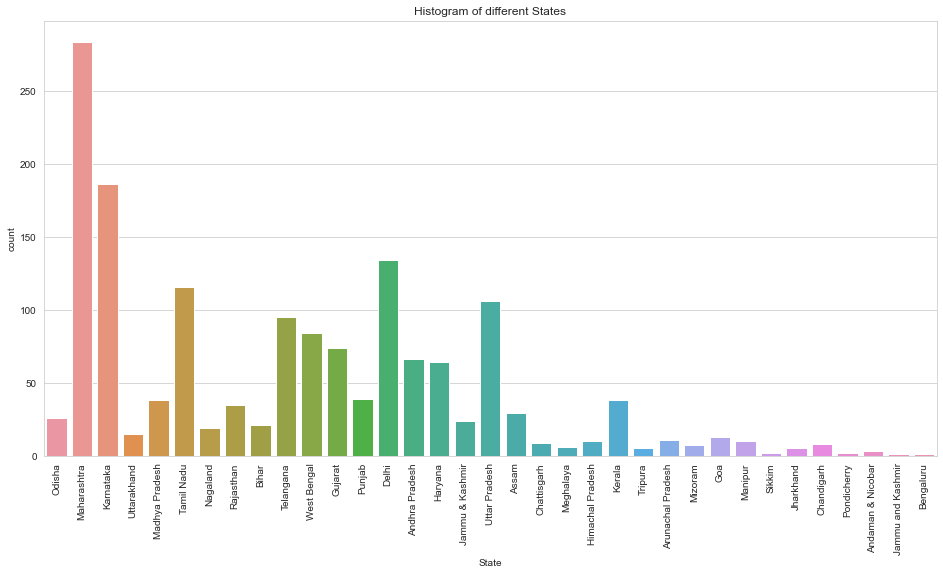

In [70]:
plt.figure(figsize=(16.0, 8.0))
sns.countplot(data=df_datetime, x="State")
plt.title("Histogram of different States")
plt.xticks(rotation=90)
plt.show()

### Status
Let's investigate the categorical feature "Status".

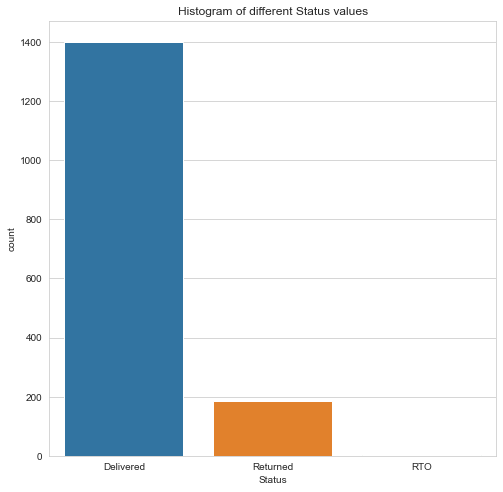

In [76]:
sns.countplot(data=df_datetime, x="Status")
plt.title("Histogram of different Status values")
plt.show()

Let's drop the two rows containing the "RTO" status value, because it is not worth imputing this data when only two rows are containing this value.

In [78]:
df_datetime = df_datetime.drop(df_datetime[df_datetime.Status == "RTO"].index)

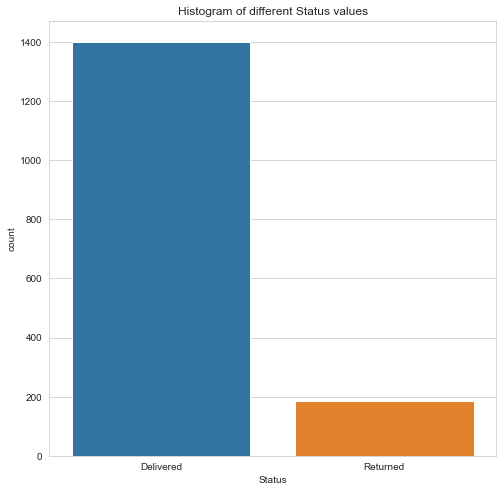

In [79]:
sns.countplot(data=df_datetime, x="Status")
plt.title("Histogram of different Status values")
plt.show()

The dataset itself is very imbalanced. So let's later check some countermeasures to balance the dataset and to avoid a biased model towards the "Delivered" status.

### Remarks
Let's investigate the categorical feature "Remarks".

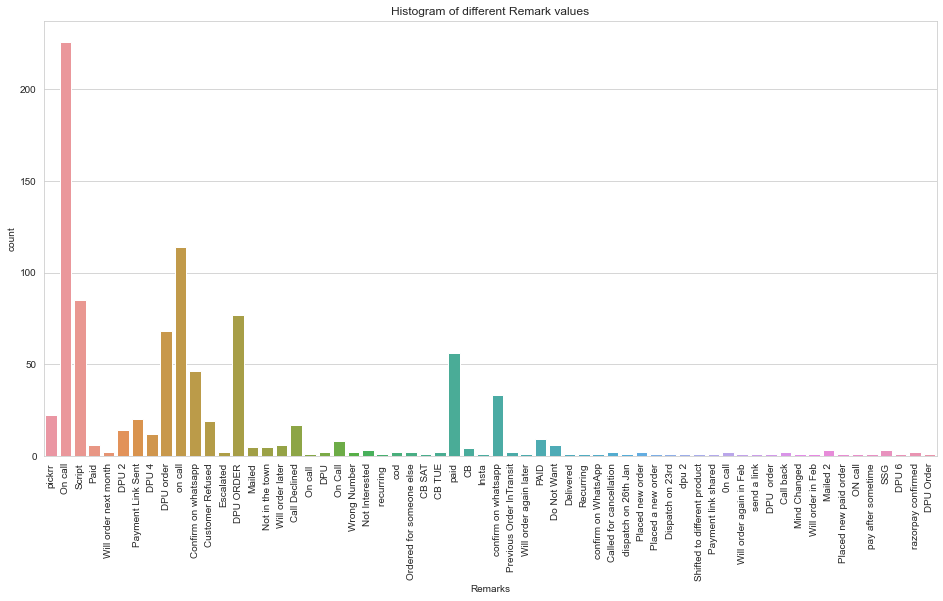

In [81]:
plt.figure(figsize=(16.0, 8.0))
sns.countplot(data=df_datetime, x="Remarks")
plt.title("Histogram of different Remark values")
plt.xticks(rotation=90)
plt.show()

There are some remark values that are only written differently (i.e. DPU order, DPU Order, CPU, DPU, ...). Let's put them together to have more meaningful features.

In [83]:
pd.set_option('display.max_rows', None)
df_datetime["Remarks"].value_counts()

On call                         226
on call                         114
Script                           85
DPU ORDER                        77
DPU order                        68
paid                             56
Confirm on whatsapp              46
confirm on whatsapp              33
pickrr                           22
Payment Link Sent                20
Customer Refused                 19
Call Declined                    17
DPU 2                            14
DPU 4                            12
PAID                              9
On Call                           8
Paid                              6
Do Not Want                       6
Will order later                  6
Not in the town                   5
Mailed                            5
CB                                4
SSG                               3
Not Interested                    3
Mailed 2                          3
DPU                               2
Called for cancellation           2
Call back                   